In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

## 1. Q-learning in the wild

Here we use the qlearning agent from before on taxi env from openai gym.
You will need to insert a few agent functions here.

In [2]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

[2017-04-17 17:04:27,319] Making new env: Taxi-v2


In [3]:
from qlearning import QLearningAgent

agent = QLearningAgent(alpha=0.5,epsilon=0.25,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

In [4]:
def play_and_train(env,agent,t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.getAction(s)
        
        next_s,r,done,_ = env.step(a)
        
        #<train (update) agent for state s>
        agent.update(s, a, next_s, r)
        
        s = next_s
        total_reward +=r
        if done:break
        
    return total_reward
    
        
    

In [12]:
eps_decay = 0.99
agent.alpha = 0.05

mean reward 7.56


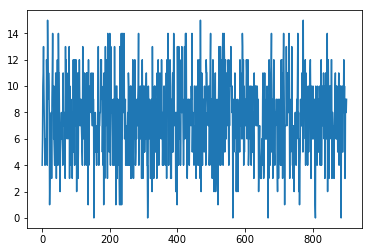

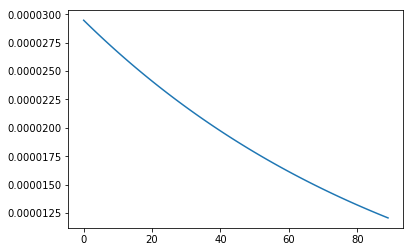

In [16]:
rewards = []
epsilons = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))    
    if i %100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()
        plt.plot(epsilons)
        plt.show()
    if i % 10 == 0:
        epsilons.append(agent.epsilon)
        agent.epsilon *= eps_decay

### 1.1 reducing epsilon

Try decreasing agent epsilon over time to make him reach positive score.

The straightforward way to do so is to reduce epsilon every N games:
* either multiply agent.epsilon by a number less than 1 (e.g. 0.99)
* or substract a small value until it reaches 0

You can, of-course, devise other strategies.

__The goal is to reach positive reward!__

## 2. SARSA (2 pts)

```<Please go to sarsa.py and implement the missing lines in update method>```

In [50]:
from sarsa import SarsaAgent
agent = SarsaAgent(alpha=0.4, epsilon=0.25, discount=0.99, getLegalActions=lambda s: range(n_actions))
#Note that SARSA will likely need smaller learning rate!

In [51]:
def play_and_train_sarsa(env,agent,t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.getAction(s)
        
        next_s,r,done,_ = env.step(a)
        
        #<train (update) agent for state s>
        agent.update(s, a, next_s, agent.getAction(next_s), r)
        
        s = next_s
        total_reward +=r
        if done:break
        
    return total_reward
    
        
    

In [59]:
agent.epsilon = 0.0

mean reward 8.27


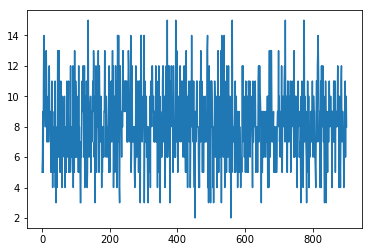

In [61]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train_sarsa(env,agent))    
    if i %100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()
        

## 3. Continuous state space (2 pts)

Use agent to train on CartPole-v0

This environment has a continuous number of states, so you will have to group them into bins somehow.

The simplest way is to use `round(x,n_digits)` (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

In [22]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n

print("first state:%s"%(env.reset()))
#plt.imshow(env.render('rgb_array'))

[2017-04-17 17:16:37,953] Making new env: CartPole-v0


first state:[-0.02093624 -0.03338724  0.01811489  0.04132009]


### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

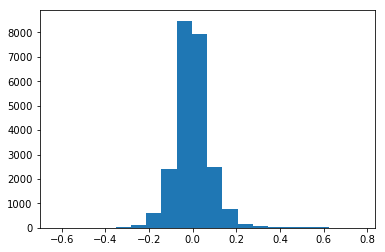

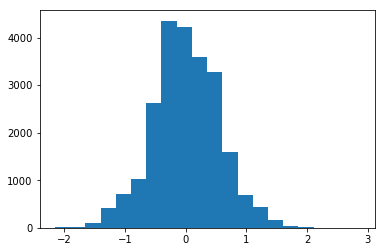

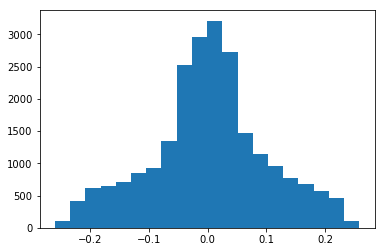

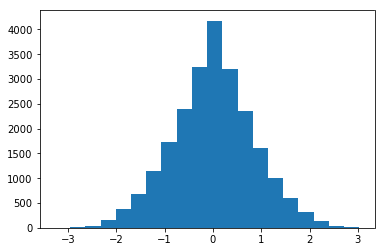

In [23]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s,r,done,_ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    
    plt.hist(all_states[:,obs_i],bins=20)
    plt.show()

## Binarize environment

In [60]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper):
    
    def _observation(self,state):    
        state = [
            int(10*state[0]),
            int(5*state[1]),
            int(20*state[2]),
            int(5*state[3])
        ]
        #state = [round(x, n) for x, n in zip(state, [5, 3, 4, 3])]
        #state = <round state to some amount digits.>
        #hint: you can do that with round(x,n_digits)
        #you will need to pick a different n_digits for each dimension

        return tuple(state)

In [61]:
env = Binarizer(gym.make("CartPole-v0"))

[2017-04-17 17:25:08,264] Making new env: CartPole-v0


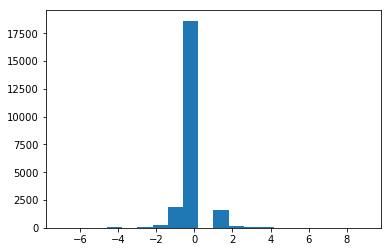

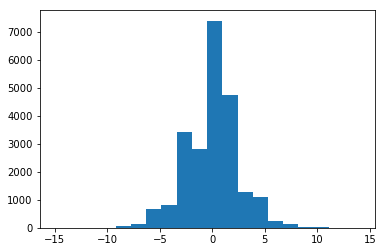

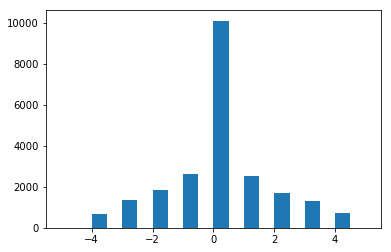

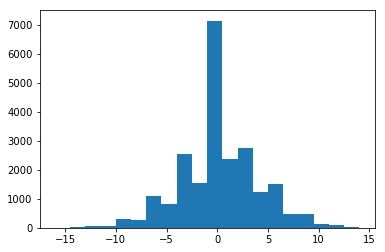

In [62]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s,r,done,_ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    
    plt.hist(all_states[:,obs_i],bins=20)
    plt.show()

## Learn

In [78]:
from qlearning import QLearningAgent
agent = QLearningAgent(alpha=0.5,epsilon=0.25,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

In [83]:
eps_decay = 0.99
agent.alpha = 0.1

In [80]:
len(agent._qValues)

0

mean reward 178.36
5.100496482485978e-10


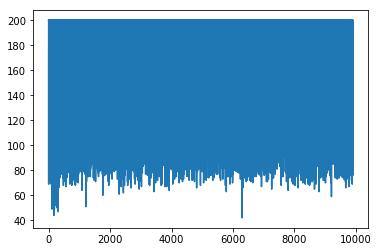

In [85]:
rewards = []
for i in range(10000):
    rewards.append(play_and_train(env,agent))    
    if i % 10 == 0:
        agent.epsilon *= eps_decay
    if i %100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        print(agent.epsilon)
        plt.plot(rewards)
        plt.show()
        

## Homework

## 4. Expected value SARSA (2 pts)

```<go to expected_value_sarsa.py and implement missing lines in getValue(state)```

In [76]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

[2017-04-17 09:13:55,541] Making new env: Taxi-v2


In [77]:
from expected_value_sarsa import EVSarsaAgent
agent = EVSarsaAgent(alpha=0.5,epsilon=0.25,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

### Train EV-SARSA

Note that it uses __the same update parameters as__ qlearning so you can use the ```play_and_train``` function from q-learning.

Please try both constant epsilon = 0.25 and decreasing epsilon.

In [78]:
def play_and_train(env, agent, t_max=10**5):
    total_reward = 0.0
    s = env.reset()
    
    for _ in range(t_max):
        a = agent.getAction(s)
        new_s, r, done, _ = env.step(a)
        agent.update(s, a, new_s, r)
        s = new_s
        total_reward += r
        if done:
            break
    return total_reward

Mean reward:  8.465


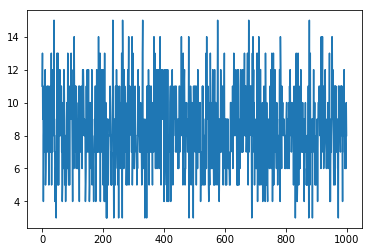

In [109]:
rewards = []
eps_decay = 0.99
for idx in range(1000):
    rewards.append(play_and_train(env, agent))
    if idx % 10 == 0:
        agent.epsilon *= eps_decay
print("Mean reward: ", np.mean(rewards))
plt.plot(rewards)
plt.show()

## 4.2 EV-sarsa on CartPole

Now train the `EVSarsaAgent` on CartPole-v0 env with binarizer you used above for Q-learning.

In [133]:
env = Binarizer(gym.make('CartPole-v1'))
n_actions = env.action_space.n
agent = EVSarsaAgent(alpha=0.5,epsilon=0.25,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

[2017-04-17 09:31:23,652] Making new env: CartPole-v1


In [134]:
def play_and_train(env, agent, t_max=10**5):
    s = env.reset()
    total_r = 0.0
    for _ in range(t_max):
        a = agent.getAction(s)
        new_s, r, done, _ = env.step(a)
        agent.update(s, a, new_s, r)
        total_r += r
        if done:
            break
    return total_r

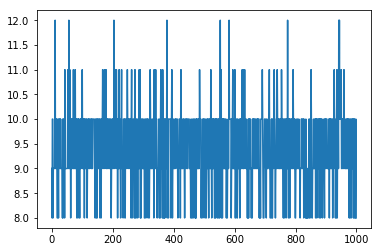

Mean rewards:  9.408


In [138]:
rewards = []
eps_decay = 0.99
for idx in range(1000):
    rewards.append(play_and_train(env, agent))
    if idx % 10 == 0:
        agent.epsilon *= eps_decay
plt.plot(rewards)
plt.show()
print("Mean rewards: ", np.mean(rewards))

# 5. Massive experiments

This is the final part of the homework. You can pick any of the 3 tasks listed below. Or take more that one and get score for each of them independently.

_If you feel to cool for this kind of school, see bonus section below - it awwards just as much points_

###  Algorithm comparison (4 points)


For this experiment, you will need to write the code to answer to compare algorithm performance and produce plots/tables with experimental results that can be used to compare them.

Take CartPole or Taxi and compare learning performance of all 3 algorithms under those conditions:

* Constant epsilon 0.25, 0.1 and 0.001
* Decreasing epsilong starting from 0.25 (decrease any way you want)
* It's probably a good idea to plot learning curves (reward / games played)
* At the end of your assignment, please describe in which conditions does each algorithm work better (if at all).

* It's also useful to double-check if experiment results are robust to re-running and if they aren't - average over several runs.
* If you use CartPole-v0, use same binarization techniques.

It is __highly recommended__ that your code automatically builds the plot or prints the table.

A creative approach to visualization or trying out more ideas will be awwarded with bonus points.


### Bonus I: Advanced algorithms (4+ points)

Implement any of the three algorithms:
* n-step expected value SARSA or Q-learning
* EV-SARSA or Q-learning( using eligibility traces aka TD(lambda)
* q-learning with experience replay

_(you will likely need to create a new file for that, just like qlearning.py)_

* Show that this algorithm works no worse than those we already implemented for simple problems. 
* Try to find a way to learn faster than with default q-learning.

You will also get +2 points for each algorithm implemented after the first one and any other awesomeness you're up to.


### Bonus II: Binarization techniques (4+ points total)

Measure how learning performance depends on binarization and try some advanced binarizations.

On CartPole-v0,
* Measure learning speed and final performance against changing the amount of bins (uniformly across all dimensions) __(1 point)__
* Try pre-processing observation with PCA, SparseCoding or any dimensionality reduction method you want, see what happens __(1 point)__

* Apply binarization to solve MountainCar-v0 or LunarLander-v2 __(+2 points each)__

_Warning, Mountaincar-v0 and LunarLander-v2 may train for ~hour. The only sanity check is that the frequency of successes more or less increases._


### Bonus II+

Try applying categorical deep autoencoder as a binarization technique.

Use gumbel-softmax, 
* Explaination and [tutorial](http://blog.evjang.com/2016/11/tutorial-categorical-variational.html), 
* [Example in lasagne](https://gist.github.com/justheuristic/fd08c15dee26dbe95d3e3a17855f3f7a/)

* If you make it work on Cartpole, it's +5. 
* If on LunarLander or MountainCar, it's +5 more.
* If it somehow ends up good on Atari (see week1 homework) or BipedalWalker-v2 or anything serious, it's a full project ( more pts :) )
* If you have any questions or need any help, feel free to ask us!
